# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import percentileofscore

### Считывание данных

Считаем данные и посмотрим на их основные характеристики.

In [2]:
data0 = pd.read_csv('/datasets/geo_data_0.csv')
data0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
data1 = pd.read_csv('/datasets/geo_data_1.csv')
data1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [4]:
data2 = pd.read_csv('/datasets/geo_data_2.csv')
data2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


### Проверка на пропуски, соответствие типов и разнообразие данных

In [5]:
data0.info()
print()
data1.info()
print()
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3

In [6]:
data0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [7]:
data1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [8]:
data2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Пропусков нет, все типы подходят, данные разные.

### Проверка мультиколлениарности признаков

In [9]:
data0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


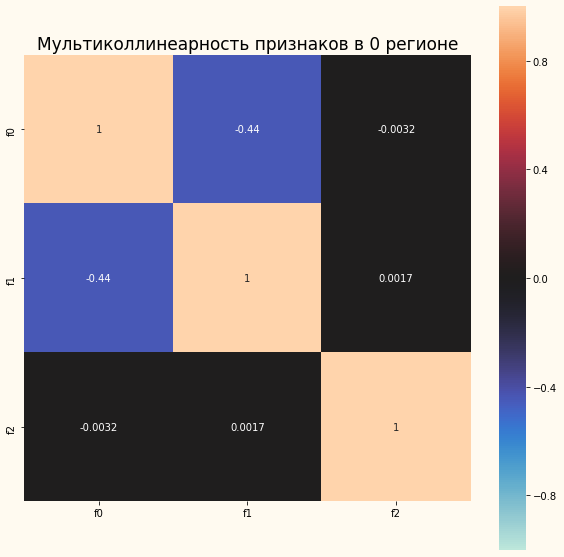

In [10]:
fig, ax = plt.subplots()
sns.heatmap(data0.drop(['product'], axis=1).corr(),vmin=-1, vmax=1, center= 0,square=True,annot=True)
ax.set_facecolor('seashell')
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_facecolor('floralwhite')
plt.title('Мультиколлинеарность признаков в 0 регионе', fontsize=17)
plt.show()

In [11]:
data1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


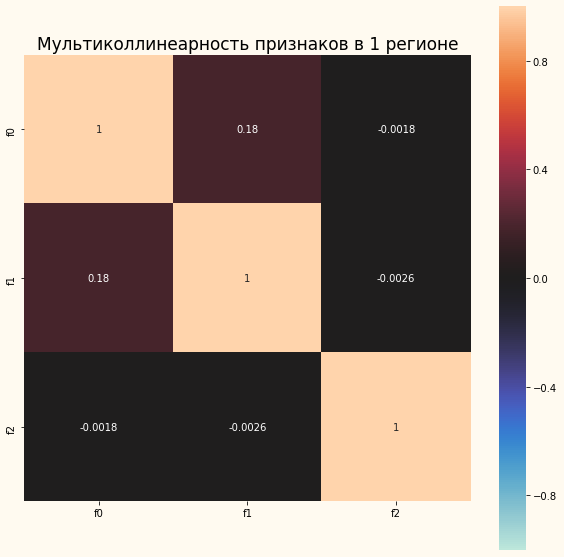

In [12]:
fig, ax = plt.subplots()
sns.heatmap(data1.drop(['product'], axis=1).corr(),vmin=-1, vmax=1, center= 0,square=True,annot=True)
ax.set_facecolor('seashell')
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_facecolor('floralwhite')
plt.title('Мультиколлинеарность признаков в 1 регионе', fontsize=17)
plt.show()

In [13]:
data2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


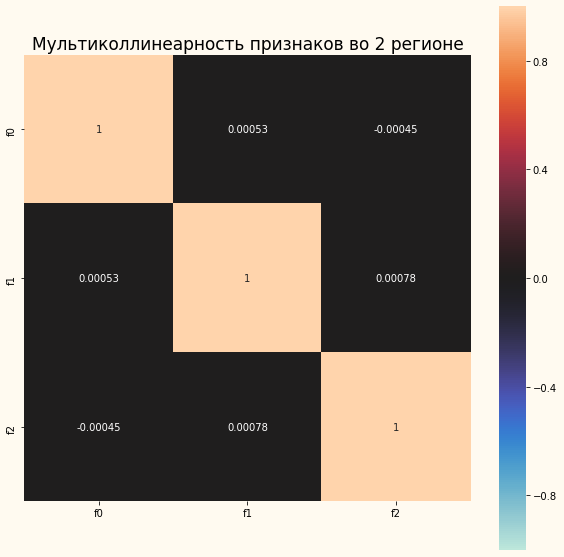

In [14]:
fig, ax = plt.subplots()
sns.heatmap(data2.drop(['product'], axis=1).corr(),vmin=-1, vmax=1, center= 0,square=True,annot=True)
ax.set_facecolor('seashell')
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_facecolor('floralwhite')
plt.title('Мультиколлинеарность признаков во 2 регионе', fontsize=17)
plt.show()

Сильнозависимых признаков нет, значит ничего лишнего удалять не будем.

### Разбиение данных на признаки и выборки

In [15]:
target0 = data0['product']
features0 = data0.drop(['id','product'], axis=1)
target1 = data1['product']
features1 = data1.drop(['id','product'], axis=1)
target2 = data2['product']
features2 = data2.drop(['id','product'], axis=1)

In [16]:
features0_train, features0_valid, target0_train, target0_valid = train_test_split(
    features0, target0, test_size=0.25,train_size=0.75, random_state=12345)

In [17]:
features1_train, features1_valid, target1_train, target1_valid = train_test_split(
    features1, target1, test_size=0.25,train_size=0.75, random_state=12345)

In [18]:
features2_train, features2_valid, target2_train, target2_valid = train_test_split(
    features2, target2, test_size=0.25,train_size=0.75, random_state=12345)

In [19]:
print(features0_train.shape,features1_train.shape,features2_train.shape)

(75000, 3) (75000, 3) (75000, 3)


In [20]:
print(target0_valid.shape,target1_valid.shape,target2_valid.shape)

(25000,) (25000,) (25000,)


Разбили все таблицы на нужные нам выборки и проверили их размерность. Данные готовы для обучения.

## Обучение и проверка модели

### Обучение моделей и поиск среднего отклонения

In [21]:
model0 = LinearRegression()
model0.fit(features0_train,target0_train)
predict0=model0.predict(features0_valid)
mse0 = mean_squared_error(target0_valid, predict0)
rmse0=mse0**0.5
rmse0

37.5794217150813

In [22]:
model1 = LinearRegression()
model1.fit(features1_train,target1_train)
predict1=model1.predict(features1_valid)
mse1 = mean_squared_error(target1_valid, predict1)
rmse1=mse1**0.5
rmse1

0.893099286775616

In [23]:
model2 = LinearRegression()
model2.fit(features2_train,target2_train)
predict2=model2.predict(features2_valid)
mse2 = mean_squared_error(target2_valid, predict2)
rmse2=mse2**0.5
rmse2

40.02970873393434

<p>В среднем наши модели ошибаются не более чем на 40 тыс. баррелей. Явно выделяется 1 регион, где разброс меньше 1 тысячи.


In [3]:
a = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
]

a_modified = []

for el in a:
    head = el[0] ** 3
    tail = el[1:]
    
    a_modified.append((head, tail))
    
a_modified

[(1, [2, 3]), (64, [5, 6]), (343, [8, 9])]

### Гистаграммы предсказаний и реальных значений

<p>Составил таблицы предсказаний и реальных значений для каждого региона, с такими будет удобнее работать в дальнейшем.
<p>Построил гистограммы каждого региона.

In [24]:
data0_predict=pd.DataFrame()
data0_predict['product']=target0_valid
data0_predict['predict']=predict0

data0_predict.head()

,product,predict
71751,10.038645,95.894952
80493,114.551489,77.572583
2655,132.603635,77.892640
53233,169.072125,90.175134
91141,122.325180,70.510088


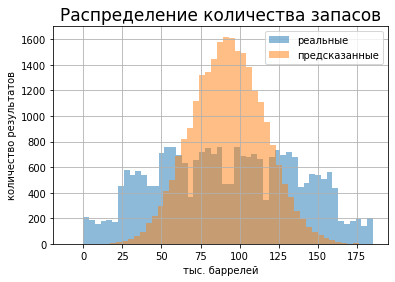

In [25]:
data0_predict['product'].hist(grid=True,label='реальные',alpha=0.5,bins=50)
data0_predict['predict'].hist(grid=True,label='предсказанные',alpha=0.5,bins=50)
plt.xlabel('тыс. баррелей')
plt.ylabel('количество результатов')
plt.title('Распределение количества запасов', fontsize=17)
plt.legend()
plt.show()

In [26]:
data1_predict=pd.DataFrame()
data1_predict['product']=target1_valid
data1_predict['predict']=predict1

data1_predict.head()

,product,predict
71751,80.859783,82.663314
80493,53.906522,54.431786
2655,30.132364,29.748760
53233,53.906522,53.552133
91141,0.000000,1.243856


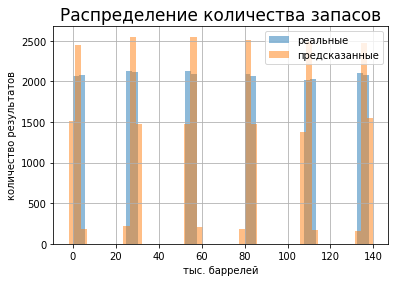

In [27]:
data1_predict['product'].hist(grid=True,label='реальные',alpha=0.5,bins=50)
data1_predict['predict'].hist(grid=True,label='предсказанные',alpha=0.5,bins=50)
plt.xlabel('тыс. баррелей')
plt.ylabel('количество результатов')
plt.title('Распределение количества запасов', fontsize=17)
plt.legend()
plt.show()

In [28]:
data2_predict=pd.DataFrame()
data2_predict['product']=target2_valid
data2_predict['predict']=predict2

data2_predict.head()

,product,predict
71751,61.212375,93.599633
80493,41.850118,75.105159
2655,57.776581,90.066809
53233,100.053761,105.162375
91141,109.897122,115.303310


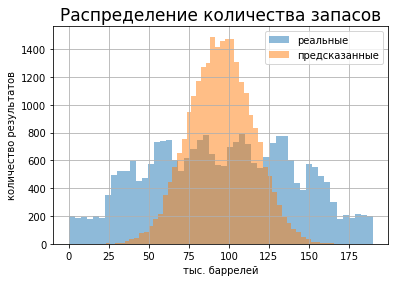

In [29]:
data2_predict['product'].hist(grid=True,label='реальные',alpha=0.5,bins=50)
data2_predict['predict'].hist(grid=True,label='предсказанные',alpha=0.5,bins=50)
plt.xlabel('тыс. баррелей')
plt.ylabel('количество результатов')
plt.title('Распределение количества запасов', fontsize=17)
plt.legend()
plt.show()

По графикам можно сделать вывод, что модель предсказывает значения ближе к среднему, чем есть на самом деле.

## Подготовка к расчёту прибыли

In [30]:
BUDGET=10**10
PRICE=450000

Средний запас скважин для безубыточной работы компании в регионе

In [31]:
min=BUDGET//PRICE//200
min

111

Чтобы производство было безубытычным нам нужно, чтобы в среднем с каждой скважины  мы получали более 111 тыс. баррелей

In [32]:
data0_predict['predict'].mean()

92.59256778438038

In [33]:
data1_predict['predict'].mean()

68.728546895446

In [34]:
data2_predict['predict'].mean()

94.96504596800489

По нашей выборке нам пока не подходит ни один такой регион (но среднее у нас посчитано исходя из 25000 месторождений, а строить мы планируем только 200 скважин)

## Расчёт прибыли и рисков на основании предсказаний

### Функции для поиска суммы топ-200 запасов в регионе и прибыли

In [35]:
def income(data):
    return data.sort_values(by='predict', ascending=False)['product'].head(200).sum()

In [36]:
def profit(data):
    return (income(data)*PRICE-BUDGET)//10**6

### Расчет запасов

In [37]:
income(data0_predict)

29601.835651421894

In [38]:
income(data1_predict)

27589.081548181137

In [39]:
income(data2_predict)

28245.22214133296

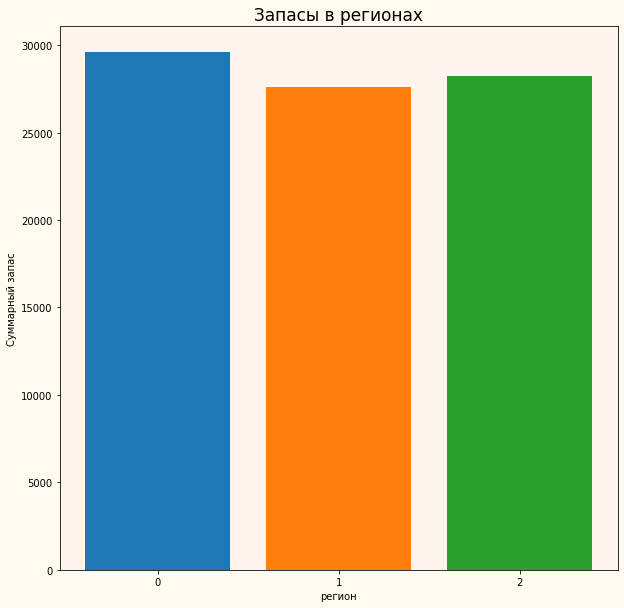

In [40]:
fig, ax = plt.subplots()
plt.bar('0',income(data0_predict))
plt.bar('1',income(data1_predict))
plt.bar('2',income(data2_predict))
ax.set_facecolor('seashell')
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_facecolor('floralwhite')
ax.set_xlabel('регион')
ax.set_ylabel('Суммарный запас')
plt.title('Запасы в регионах', fontsize=17)
plt.show()

Предсказанные значения в каждом регионе получились соизмеримыми.

### Расчет прибыли

In [41]:
profit(data0_predict)

3320.0

In [42]:
profit(data1_predict)

2415.0

In [43]:
profit(data2_predict)

2710.0

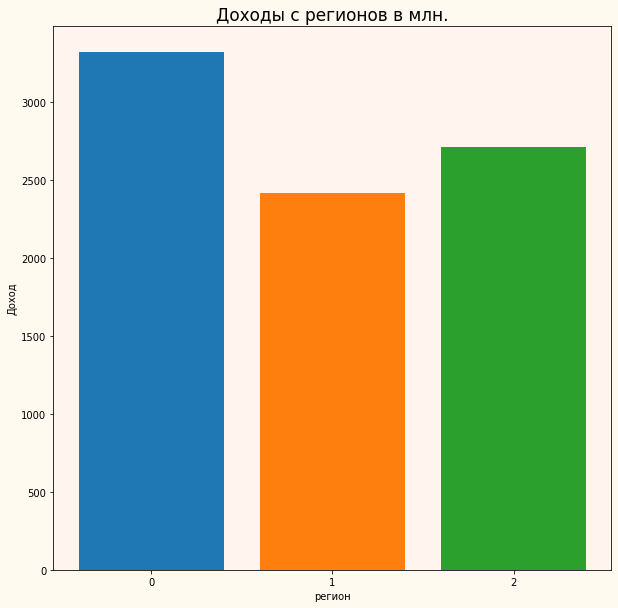

In [44]:
fig, ax = plt.subplots()
plt.bar('0',profit(data0_predict))
plt.bar('1',profit(data1_predict))
plt.bar('2',profit(data2_predict))
ax.set_facecolor('seashell')
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_facecolor('floralwhite')
ax.set_xlabel('регион')
ax.set_ylabel('Доход')
plt.title('Доходы с регионов в млн.', fontsize=17)
plt.show()

Доходы с первого региона значительно выше остальных.

## Риски и прибыль для каждого региона

### Функция Bootstrap 

In [45]:
def doBoot(data):
    state = np.random.RandomState(12345)
    
    values = []
    for i in range(1000):
        target_subsample = data['product'].sample(500, replace=True, random_state=state)
        probs_subsample = data['predict'][target_subsample.index] 
        
        new_data=pd.DataFrame()
        new_data['product']=target_subsample
        new_data['predict']=probs_subsample
    
        values.append(profit(new_data))
    incomes=pd.Series(values)
    
    lower=incomes.quantile(0.025)
    upper=incomes.quantile(0.975)
    
    mean=incomes.mean()
    
    risk=percentileofscore(incomes,0)
    
    plt.hist(incomes,bins=50)
    plt.title('Распределение выручки')
    plt.xlabel('Выручка')
    plt.ylabel('Количество')
    
    print('Среднее значение прибыли: {:.0f} млн.'.format(mean))
    print('95 % доверительный интервал прибыли: от {:.0f} млн. до {:.0f} млн.'.format(lower,upper))
    print('Риски: {:.2}%'.format(risk))

### Подсчёт значений для каждого региона

Среднее значение прибыли: 396 млн.
95 % доверительный интервал прибыли: от -112 млн. до 909 млн.
Риски: 6.9%


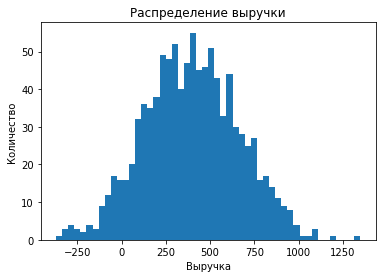

In [46]:
doBoot(data0_predict)

Среднее значение прибыли: 456 млн.
95 % доверительный интервал прибыли: от 33 млн. до 852 млн.
Риски: 1.5%


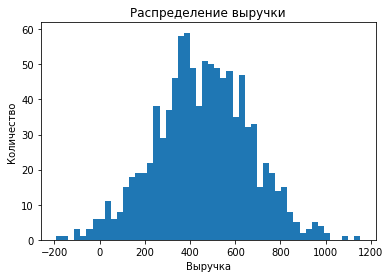

In [47]:
doBoot(data1_predict)

Среднее значение прибыли: 404 млн.
95 % доверительный интервал прибыли: от -164 млн. до 950 млн.
Риски: 7.7%


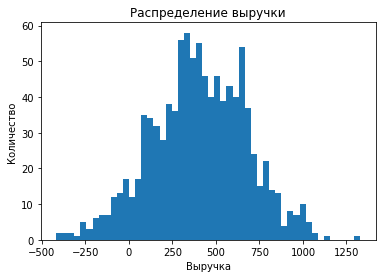

In [48]:
doBoot(data2_predict)

### Вывод 

По двум параметрам нам подходит регион №1, у него максимальная средняя выручка и минимальные риски.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован